# Feature Map PreProcessing #

## This part of code are aimed to find the pattern in the feature map generated from the last script. Then create the feature map for 0K ##

In [ ]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.models import Sequential
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.layers import Dropout, Activation, Dense, Flatten
from numpy import expand_dims

# Data Loading and Index Created_Train Splitting #

In [2]:
Val=pd.read_csv('WXProjectWholeData.csv').T
num=3
Tem=[300,600,800]
for k in range(3):
    for j in range(num):
        Tem.insert(j+1,(Tem[j]+Tem[j+1])/2)
for k in range(3):
    for j in range(num):
        Tem.insert(-j-1,(Tem[-j-1]+Tem[-j-2])/2)
print(Tem)
len(Tem)
X_train, X_test, y_train, y_test = train_test_split(Val.values, Tem, test_size=0.15, random_state=13)
y_train = np.array(y_train)
y_train = y_train.reshape(y_train.shape + (1,))

[300, 337.5, 356.25, 365.625, 375.0, 412.5, 431.25, 450.0, 525.0, 562.5, 600, 625.0, 650.0, 700.0, 712.5, 725.0, 750.0, 756.25, 762.5, 775.0, 800]


# Model Info, Same with last time #

In [3]:
model = Sequential()
activation = 'relu'
model.add(Dense(64, input_dim = X_train.shape[1],activation=activation))
model.add(Dense(128, activation=activation))
model.add(Dense(64, activation=activation))
model.add(Dense(64, activation=activation))
model.add(Dense(1, activation=activation))
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                34688     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 55,489
Trainable params: 55,489
Non-trainable params: 0
_________________________________________________________________
None


# The Best Weight Loading and Test Data Created #

In [4]:
weights='3Weights-2489--1.32339.hdf5'
model.load_weights(weights)

In [5]:
ori=np.array(Val.values)
ori

array([[-3.72573464e-06,  4.52599782e-06,  2.90884735e-06, ...,
         5.09579103e-06,  4.92752643e-06,  8.18467060e-06],
       [-3.90207983e-06,  4.17984712e-06,  2.00002552e-06, ...,
         4.87335934e-06,  5.35332644e-06,  6.17519148e-06],
       [-3.99025243e-06,  4.00677177e-06,  1.54561461e-06, ...,
         4.76214350e-06,  5.56622645e-06,  5.17045192e-06],
       ...,
       [-6.99032362e-07, -7.90589418e-06, -2.08097165e-06, ...,
        -1.42306346e-05, -3.08746868e-06, -1.94764019e-05],
       [-3.57688991e-07, -8.64917775e-06, -1.90552891e-06, ...,
        -1.55804017e-05, -3.96603755e-06, -2.03675742e-05],
       [ 3.24997752e-07, -1.01357449e-05, -1.55464343e-06, ...,
        -1.82799358e-05, -5.72317528e-06, -2.21499187e-05]])

# Feature Map Plotting #

In [6]:
from keras.models import Model
ixs=[0,1,2,3]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)

In [7]:
fea=model.predict(ori)
plt.plot(fea[0][0])

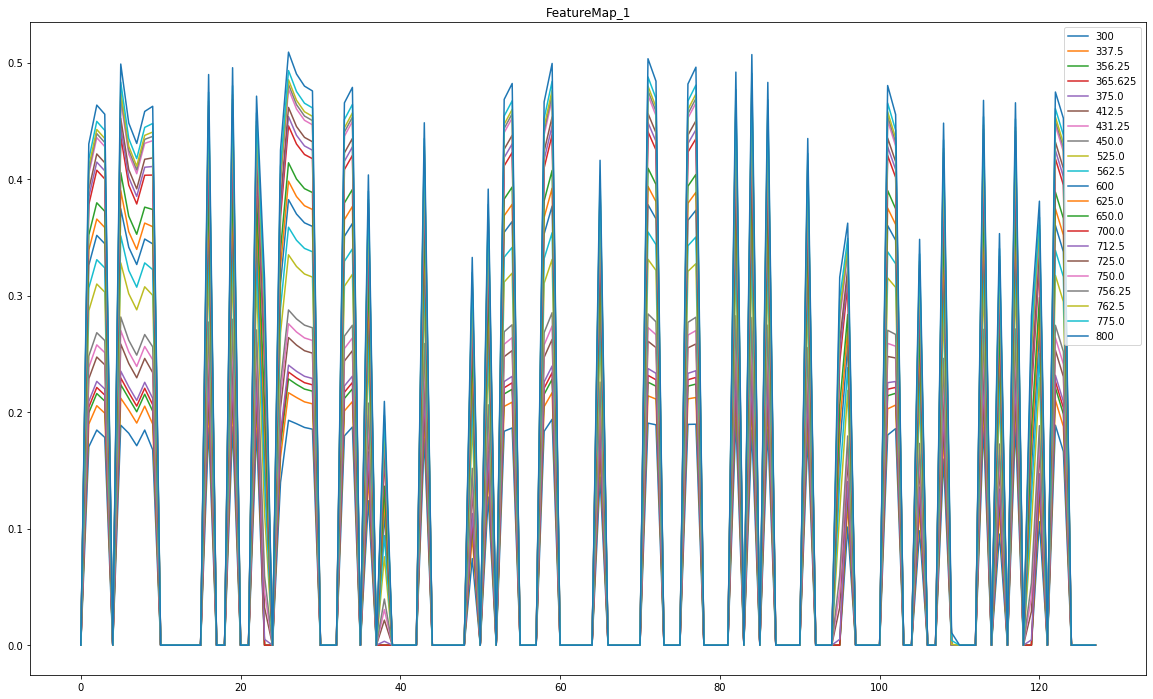

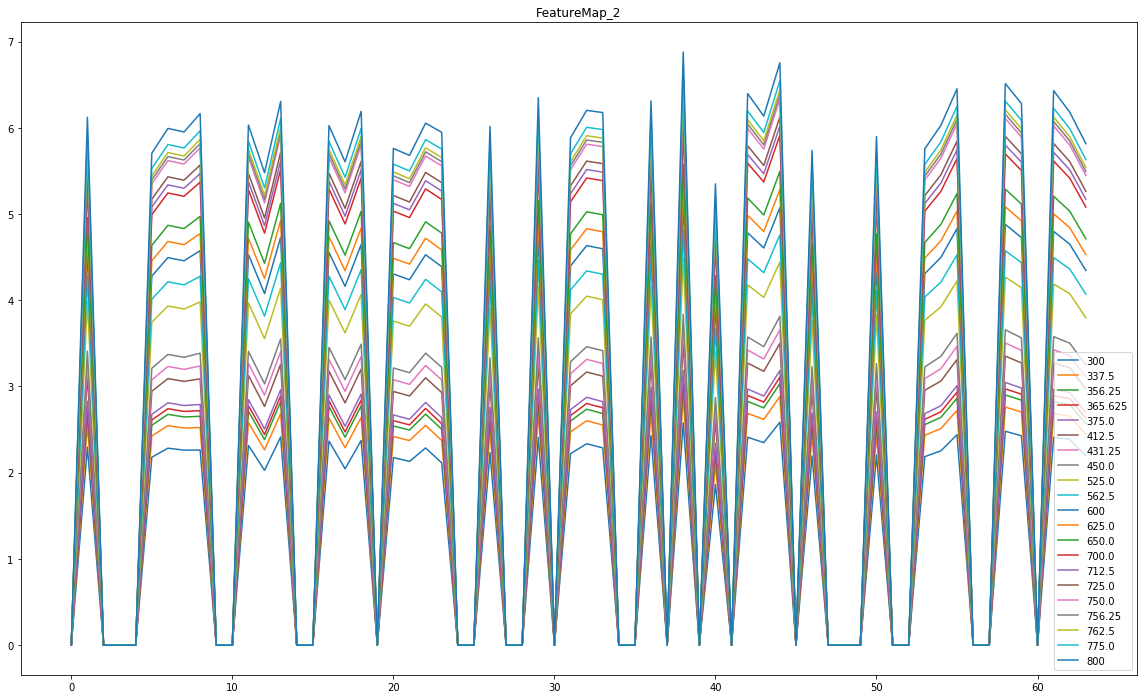

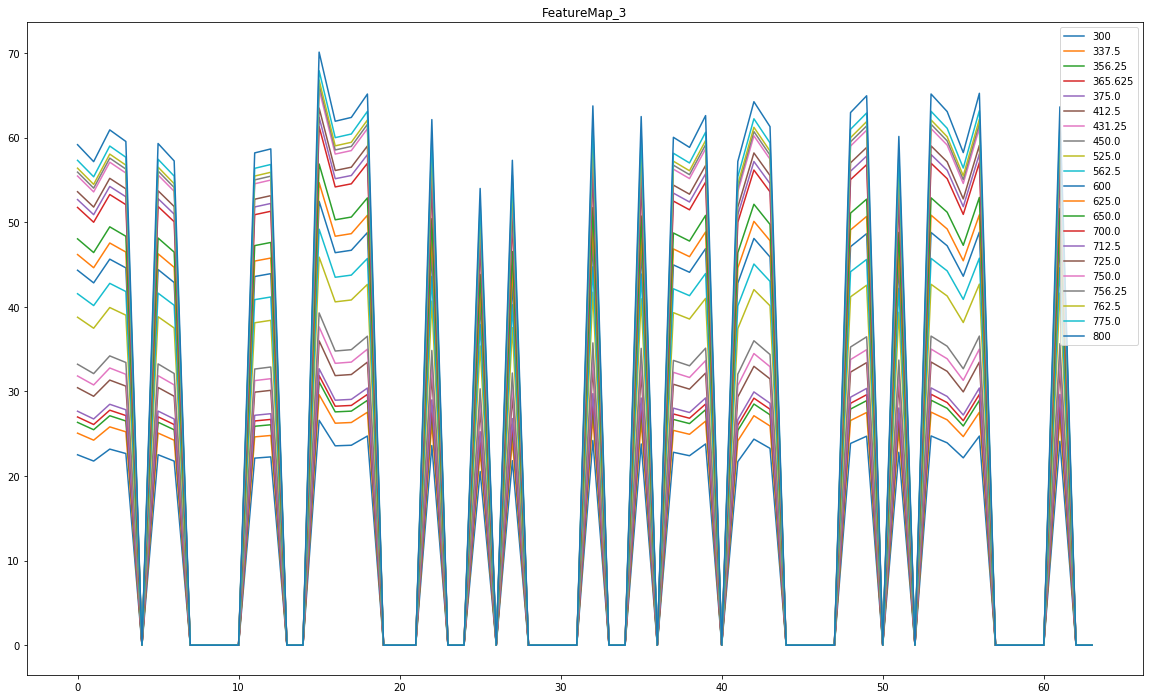

In [9]:
label=Tem
for i in range(1,len(fea)):
    fig= plt.figure(figsize=(20,12))
    for j in range(len(fea[0])):
        plt.plot(fea[i][j],label=label[j])
        plt.legend()
    plt.title('FeatureMap_{}'.format(i))
    plt.savefig('Map_{}.png'.format(i),dpi=1200)

# Feature Data Collection #

In [6]:
D800=fea[1][4]
D450=fea[1][1]
D600=fea[1][2]
D750=fea[1][3]
D300=fea[1][0]
label=Tem
tol=[D300,D450,D600,D750,D800]
def R0(D):
    new=[]
    for i in D:
        if i>1e-5:
            new.append(i)
    f=np.array(new)
    return f
F={}
co=0
for j in tol:
    F['{}K'.format(label[co])]=j
    co+=1
df=DataFrame(F)
df

NameError: name 'fea' is not defined

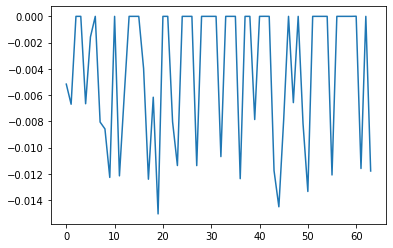

In [101]:
from scipy import stats
#for jj in range(1,4):  
x=np.array([300,450,600,750,800])
new=[]
for jj in range(1,df.shape[0]+1):
    y=df.iloc[jj-1:jj].values[0]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    new.append(intercept)
plt.plot(new)
#plt.plot(df.iloc[:,0:1])

In [12]:
filters, biases = model.layers[1].get_weights()
filters.shape

(541, 64)

# Feature Map Data Collection to .csv #

### Because the Activation Function Used in the Neural Net Work is ReLu, all the negative data will be 0 automatically. Thus, to preserve the data in that area, the kernel is being extracted and use to create the Feature Map###

In [14]:
ff={}
for ii in range(ori.shape[0]):
    x1=np.dot(ori[ii],filters)+biases
    ff['{}K'.format(Tem[ii])]=x1
df=DataFrame(ff)
df.set_index('300K',inplace=True)
df.to_csv('FeatureMap1.csv')

In [3]:
df=pd.read_csv('FeatureMap1.csv').T

# The Pattern Observation and Interpolation #

**The feature map shows clearly the linear relationship exist between different temperature, thus, apply linear regression to the data, so we can find the feature map in 0K**

In [12]:
from scipy import stats
T0=[]
T50=[]
T100=[]
T150=[]
T200=[]
T250=[]
for i in range(1,df.shape[1]+1):
    y=df.iloc[:,i-1:i].values.flatten()
    slope, intercept, r_value, p_value, std_err = stats.linregress(Tem, y)
    T0.append(intercept)
    T50.append(50*slope+intercept)
    T100.append(100*slope+intercept)
    T200.append(200*slope+intercept)
    T250.append(250*slope+intercept)
    T150.append(150*slope+intercept)
Tot={}
Tot['0K']=T0
Tot['50K']=T50
Tot['100K']=T100
Tot['150K']=T150
Tot['200K']=T200
Tot['250K']=T250
dff=DataFrame(Tot)
dff.set_index('0K',inplace=True)

In [13]:
dff.to_csv('Predict_tem.csv')

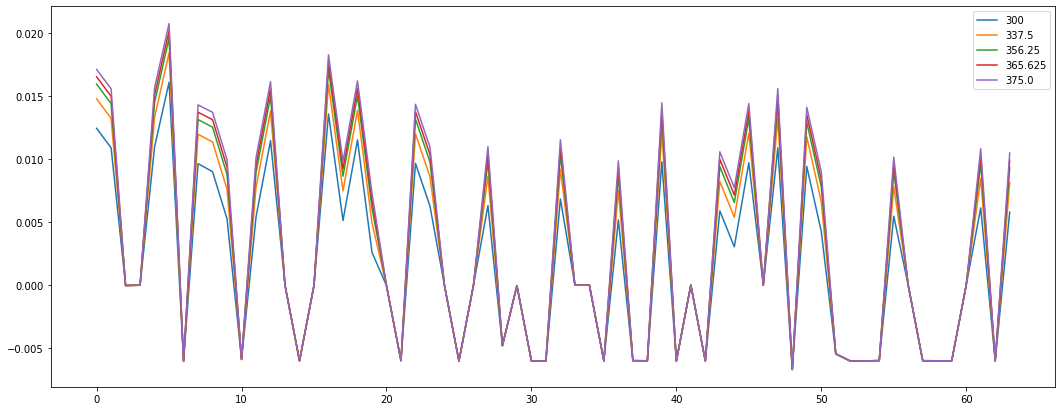

In [38]:
fig= plt.figure(figsize=(18,7))
for i in range(5):
    plt.plot(np.dot(ori[i],filters)+biases,label=Tem[i])
    plt.legend()

# The Linear Relationship showing and Interpolation Line #

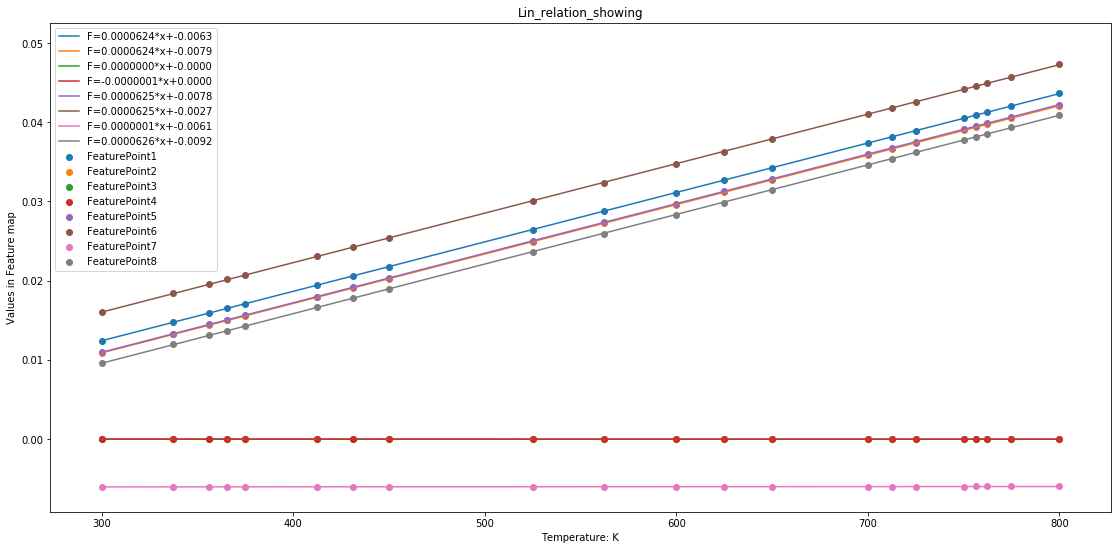

In [25]:
from scipy import stats
fig= plt.figure(figsize=(19,9))
df=pd.read_csv('FeatureMap1.csv').T
for i in range(1,9):
    y=df.iloc[:,i-1:i].values.flatten()
    plt.scatter(Tem,y,label='FeaturePoint{}'.format(i))
    slope, intercept, r_value, p_value, std_err = stats.linregress(Tem, y)
    xnew=np.linspace(300,800,50)
    plt.plot(xnew,xnew*slope+intercept,label='F={}*x+{}'.format("%.7f" % slope,"%.4f" % intercept))
plt.xlabel('Temperature: K')
plt.ylabel('Values in Feature map')
plt.title('Lin_relation_showing')
plt.legend()
plt.savefig('Si{}.png'.format(i))

In [14]:
df

,50K,100K,150K,200K,250K
0K,,,,,
-0.006324,-0.003204,-0.000084,0.003037,6.156945e-03,0.009277
-0.007853,-0.004733,-0.001613,0.001506,4.626331e-03,0.007746
-0.000045,-0.000043,-0.000041,-0.000039,-3.738724e-05,-0.000035
0.000020,0.000017,0.000014,0.000011,7.251280e-06,0.000004
-0.007819,-0.004692,-0.001566,0.001561,4.687890e-03,0.007815
...,...,...,...,...,...
-0.005978,-0.005980,-0.005982,-0.005984,-5.985445e-03,-0.005987
0.000009,0.000007,0.000004,0.000002,-2.327148e-07,-0.000003
-0.012765,-0.009625,-0.006484,-0.003344,-2.036619e-04,0.002937
